The code in this file has been arranged according to the order in which I have done the execution.

The neccessary comments are added before execution of each steps.

The prerequisite for running are below:-
1. One must execute this file in Windows. Since the file structure's traversal is in windows format. The same can be made os agnostic with change in a few lines of code. For simplicity purpose I have chosen Windows OS.
2. One must have following dependencies installed beforhand:-
    Anaconda with Python 3.7 (this bring in most of the dependencies)
    Keras 2.1.2 (Mobilenet models will not have issues with this version)

Note: This is a prototypical version of the code with ample of room for improvements/refactoring

Download the files from datasource and unzip it in the Download folder

In [1]:
import numpy as np
from os import listdir
from os.path import isfile, join
import os

In [2]:
base = os.getcwd()
dir_healthy = base + '\Downloads\YE358311_Fender_apron\YE358311_Healthy'
dir_defects = base + '\Downloads\YE358311_Fender_apron\YE358311_defects\YE358311_Crack_and_Wrinkle_defect'

The below code is used for doing the train test validation splits before even moving the files to the respective structure

In [3]:
healthy_list = [ f for f in listdir(dir_healthy) if isfile(join(dir_healthy, f))]
healthy_list = np.array([ healthy_list , [1] * len(healthy_list)])
defect_list  = [ f for f in listdir(dir_defects) if isfile(join(dir_defects, f))]
defect_list  = np.array([ defect_list , [0] * len(defect_list)])

In [4]:
files = np.concatenate((defect_list, healthy_list), axis = 1)

In [5]:
from sklearn.model_selection import train_test_split

In [6]:
X_train, X_test, y_train, y_test = train_test_split(files[0], files[1], test_size=0.2, random_state=29)

In [7]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=29)

The main idea for doing the above work is to convert the already existing input into below directory structure so that the user can track his splits and the same can be used by flow_from_directory function of Keras's preprocessing's ImageDataGenerator to pick in the image files and create batches for training

```
Create folder structure 
-Data
    -Train
        -defect
        -healthy
    -Test
        -defect
        -healthy
    -Validation
        -defect
        -healthy
```

In [8]:
base_location = base + '\Downloads\YE358311_Fender_apron'
data_loc = '\\data'
train_loc = '\\data\\train'
train_defects_loc = '\\data\\train\\defects'
train_heathy_loc = '\\data\\train\\healthy'
test_loc = '\\data\\test'
test_defects_loc = '\\data\\test\\defects'
test_heathy_loc = '\\data\\test\\healthy'
val_loc = '\\data\\val'
val_defects_loc = '\\data\\val\\defects'
val_heathy_loc = '\\data\\val\\healthy'

locations = [data_loc, train_loc, train_defects_loc, train_heathy_loc, test_loc, test_defects_loc,
             test_heathy_loc, val_loc, val_defects_loc, val_heathy_loc]

for loc in locations:
    if not os.path.exists(base_location + loc):
        os.mkdir(base_location + loc)

Once we run the above code we get the directory structure if it already doesn't exists.
Now in the below part we copy the files from the downloaded directory to the directory structure which we created in the previous steps, the train test validation splits which we already did will come in handy in properly placing those files in their respective correct locations.

In [9]:
from shutil import copyfile

In [10]:
data_array = [X_train, X_test, X_val]
for data in data_array:
    for file_name in data:
        if file_name in X_train:
            if os.path.isfile(dir_healthy + '\\' + file_name):
                if not os.path.isfile(base_location + train_heathy_loc + "\\" + file_name):
                    copyfile(dir_healthy + '\\' + file_name, base_location + train_heathy_loc + "\\" + file_name)
            else:
                if not os.path.isfile(base_location + train_defects_loc + "\\" + file_name):
                    copyfile(dir_defects + '\\' + file_name, base_location + train_defects_loc + "\\" + file_name)  
        elif file_name in X_test:
            if os.path.isfile(dir_healthy + '\\' + file_name):
                if not os.path.isfile(base_location + test_heathy_loc + "\\" + file_name):
                    copyfile(dir_healthy + '\\' + file_name, base_location + test_heathy_loc + "\\" + file_name)
            else:
                if not os.path.isfile(base_location + test_defects_loc + "\\" + file_name):
                    copyfile(dir_defects + '\\' + file_name, base_location + test_defects_loc + "\\" + file_name)  
        else:
            if os.path.isfile(dir_healthy + '\\' + file_name):
                if not os.path.isfile(base_location + test_heathy_loc + "\\" + file_name):
                    copyfile(dir_healthy + '\\' + file_name, base_location + val_heathy_loc + "\\" + file_name)
            else:
                if not os.path.isfile(base_location + test_defects_loc + "\\" + file_name):
                    copyfile(dir_defects + '\\' + file_name, base_location + val_defects_loc + "\\" + file_name)

We will be using transfer learning for solving this problem. I have reached to this particular approach before trying some of the deep models based on existing architectures and found that a pretrained model on a large dataset would work nicely for this problem. So after trying multiple architectures I stuck with MobileNet architecture. The most striking reason for this choice was its small size and high accuracy. Given in the problem statement it was mentioned that we have to make this model work for mobile devices as well so I think a (< 20 Mb model) would easily fit into mobile devices and would performed decently well.

In [11]:
import keras
from keras.preprocessing.image import ImageDataGenerator

Using TensorFlow backend.


In [12]:
train_path = base_location + train_loc
test_path = base_location + test_loc
val_path = base_location + val_loc

Since we want to apply same preprocessing as it was done in the MobileNet so I have used the preprocessing function which was used in the preprocessing of MobileNet. I have used image size of 224 * 224 * 3 since its a defacto size of most of the pretrained models including the MobileNet as well. I am using batch size of 32 for training and 10 for test and validation

In [13]:
train_batches = ImageDataGenerator(preprocessing_function=keras.applications.mobilenet.preprocess_input).flow_from_directory(train_path, target_size=(224,224), classes=['defects','healthy'], batch_size=32)
test_batches = ImageDataGenerator(preprocessing_function=keras.applications.mobilenet.preprocess_input).flow_from_directory(test_path, target_size=(224,224), classes=['defects','healthy'], batch_size=10, shuffle=False)
val_batches = ImageDataGenerator(preprocessing_function=keras.applications.mobilenet.preprocess_input).flow_from_directory(val_path, target_size=(224,224), classes=['defects','healthy'], batch_size=10)

Found 160 images belonging to 2 classes.
Found 50 images belonging to 2 classes.
Found 40 images belonging to 2 classes.


In [14]:
import keras
from keras import backend as K
from keras.models import Sequential
from keras.layers import Activation
from keras.layers.core import Dense, Flatten
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import *
from sklearn.metrics import confusion_matrix

In [15]:
import keras
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from sklearn.metrics import confusion_matrix

Downloading the MobileNet model from the Keras applications and having a look at its architecture

In [16]:
mobile = keras.applications.mobilenet.MobileNet()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [17]:
mobile.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (Activation)      (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
_________________________________________________________________
conv_dw_1_relu (Activation)  (None, 112, 112, 32)      0         
__________

Since the last 5 layers of the exiting MobileNet model is specifically designed for Imagenet dataset so we take the output of the last 6th layer and add a Dense layer with 2 neurons in the end. We use softmax activation for this layer and this will be our last layer. This layer will basically contain our predictions.

In [18]:
previous_layers = mobile.layers[-6].output
last_layer = Dense(2, activation='softmax')(previous_layers)

Configuring a Keras functional model and checking the summary of the model.

In [19]:
model = Model(inputs = mobile.input, output = last_layer)

C:\Users\rs250117\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  """Entry point for launching an IPython kernel.


In [20]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (Activation)      (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
_________________________________________________________________
conv_dw_1_relu (Activation)  (None, 112, 112, 32)      0         
__________

There are in total 84 layers and we are letting the training happen the last 24 layers. We freeze the initial layers. For this dataset 24 turned out to be most accurate. This is a hyperparameter and we can try out for other values as well.

In [21]:
for layers in model.layers[:-24]:
    layers.trainable = False

Compliling the model with Adam optimizer, keeping the learning rate on a slighlty lower side at 0.0001 and using categorical cross entropy loss. We are using metrics as accuracy.

In [22]:
model.compile(Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

Running the training for 9 epochs. 9 because I tried with multiple value and found 9 to be more accurate.

In [23]:
model.fit_generator(train_batches, steps_per_epoch=5, validation_data=val_batches, validation_steps=4, epochs=9, verbose=2)

Instructions for updating:
Use tf.cast instead.
Epoch 1/9
 - 68s - loss: 0.7288 - acc: 0.6000 - val_loss: 0.6020 - val_acc: 0.6750
Epoch 2/9
 - 49s - loss: 0.2435 - acc: 0.9313 - val_loss: 0.5710 - val_acc: 0.7250
Epoch 3/9
 - 50s - loss: 0.0955 - acc: 0.9938 - val_loss: 0.5466 - val_acc: 0.6750
Epoch 4/9
 - 49s - loss: 0.0456 - acc: 1.0000 - val_loss: 0.5179 - val_acc: 0.7250
Epoch 5/9
 - 50s - loss: 0.0358 - acc: 1.0000 - val_loss: 0.4769 - val_acc: 0.7250
Epoch 6/9
 - 46s - loss: 0.0175 - acc: 1.0000 - val_loss: 0.4537 - val_acc: 0.7250
Epoch 7/9
 - 45s - loss: 0.0129 - acc: 1.0000 - val_loss: 0.4411 - val_acc: 0.8000
Epoch 8/9
 - 47s - loss: 0.0144 - acc: 1.0000 - val_loss: 0.4323 - val_acc: 0.8000
Epoch 9/9
 - 51s - loss: 0.0071 - acc: 1.0000 - val_loss: 0.4274 - val_acc: 0.8000


The function to plot the testing result in confusion matrix so that it can be visualized easily. For this purpose I have used the existing code over the net.

In [24]:
import matplotlib.pyplot as plt
import itertools
%matplotlib inline

In [25]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion Matrix', cmap=plt.cm.Blues):
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print('Confusion matrix with normalization')
    else:
        print('Confusion matrix without normalization')
    
    print(cm)
    
    thresh = cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i,j], horizontalalignment = 'center', color='white' if cm[i, j] > thresh else 'black')
    
    plt.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')

Getting the testing labels from the test batches so that they can act as the true value for our testing data

In [26]:
test_labels = test_batches.classes

In [27]:
test_labels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1])

In [28]:
test_batches.class_indices

{'defects': 0, 'healthy': 1}

Generating our results from the model. Steps have been taken as 5 because there are 50 examples and we have already defined the test batch size as 10

In [29]:
predictions = model.predict_generator(test_batches, steps = 5, verbose = 1)

5/5 [==============================] - 13s 3s/step


In [30]:
predictions[:5]

array([[0.96928734, 0.03071272],
       [0.82346934, 0.17653072],
       [0.92239976, 0.07760025],
       [0.99287295, 0.00712706],
       [0.9590192 , 0.04098085]], dtype=float32)

Generated predictions are in the format [[x, y], ... ,[x, y]] where x is the probability of sample being a defective sample and y is the probability of sample being healthy. We require the results to be in same format for comparing with the actual results so we use np.argmax() function with axis specified as 1 which will convert the results into the same format.

In [31]:
new_pred = np.argmax(predictions, axis = 1)

In [32]:
new_pred

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 1], dtype=int64)

Now we have the predicted and actual labels so we create confusion matrix to compare these results

In [33]:
cm = confusion_matrix(test_labels, new_pred)

In [34]:
cm_plot_labels = ['defects','healthy']

Confusion matrix without normalization
[[21  0]
 [ 5 24]]


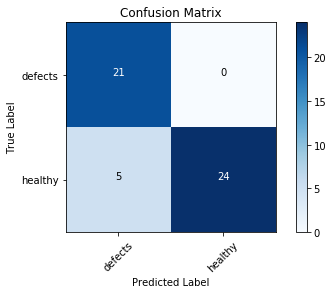

In [35]:
plot_confusion_matrix(cm, cm_plot_labels, title='Confusion Matrix')

##### We see the accuracy is pretty good standing at 90% for a quicky trained model. So we save the model. 

Saving the model structure into json format and model weights in h5 format so that the same can be used at a later stage

In [36]:
model_json = model.to_json()
with open(base_location + "\\model.json", "w") as json_file:
    json_file.write(model_json)

In [37]:
model.save_weights(base_location + "\\model.h5")